In [198]:
import pandas as pd
import numpy as np
import zipfile
import seaborn as sns

import requests
from lxml import html
import re
import time
import datetime
from nltk.stem.snowball import SnowballStemmer
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD

from matplotlib import pyplot as plt
import scipy.stats as st
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV, LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer, LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler 

from sklearn.model_selection import cross_val_score
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans


%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## Получение данных

In [ ]:
df = pd.read_csv('hakaton.csv')
print(df.shape)
df.head()

(328572, 16)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,social_type,text,has_images,has_videos,url,likes,comments,reposts,views,is_repost,created_date,updated_date,version,author_id,id,author_subscribers
0,odnoklassniki,"<div data-tid=""152651712709506"" data-l=""ti,152...",1,0,https://ok.ru/group/42559086985346/topic/15265...,20,2,0,-1,0,2021-04-07 06:30:00,2021-04-07 16:40:11,2,42559086985346,group/42559086985346/topic/152651712709506,682150
1,odnoklassniki,"<div data-tid=""152651712709506"" data-l=""ti,152...",1,0,https://ok.ru/group/42559086985346/topic/15265...,23,3,0,-1,0,2021-04-07 06:30:00,2021-04-08 15:07:33,4,42559086985346,group/42559086985346/topic/152651712709506,682138
2,odnoklassniki,"<div data-tid=""152651712709506"" data-l=""ti,152...",1,0,https://ok.ru/group/42559086985346/topic/15265...,23,3,0,-1,0,2021-04-06 21:00:00,2021-04-09 05:17:45,6,42559086985346,group/42559086985346/topic/152651712709506,682137
3,odnoklassniki,"<div data-tid=""152651712709506"" data-l=""ti,152...",1,0,https://ok.ru/group/42559086985346/topic/15265...,23,3,0,-1,0,2021-04-06 21:00:00,2021-04-09 17:17:49,8,42559086985346,group/42559086985346/topic/152651712709506,682149
4,odnoklassniki,"<div data-tid=""152651712709506"" data-l=""ti,152...",1,0,https://ok.ru/group/42559086985346/topic/15265...,23,3,0,-1,0,2021-04-06 21:00:00,2021-04-10 06:12:21,10,42559086985346,group/42559086985346/topic/152651712709506,682149


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328572 entries, 0 to 328571
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   social_type         328572 non-null  object
 1   text                318241 non-null  object
 2   has_images          328572 non-null  int64 
 3   has_videos          328572 non-null  int64 
 4   url                 328572 non-null  object
 5   likes               328572 non-null  int64 
 6   comments            328572 non-null  int64 
 7   reposts             328572 non-null  int64 
 8   views               328572 non-null  int64 
 9   is_repost           328572 non-null  int64 
 10  created_date        328572 non-null  object
 11  updated_date        328572 non-null  object
 12  version             328572 non-null  int64 
 13  author_id           328572 non-null  int64 
 14  id                  328572 non-null  object
 15  author_subscribers  328572 non-null  int64 
dtypes:

In [ ]:
df.apply(lambda x: x.isna().sum())

social_type               0
text                  10331
has_images                0
has_videos                0
url                       0
likes                     0
comments                  0
reposts                   0
views                     0
is_repost                 0
created_date              0
updated_date              0
version                   0
author_id                 0
id                        0
author_subscribers        0
dtype: int64

In [ ]:
df[df['text'].isna()].groupby('social_type').size()

social_type
odnoklassniki    1171
telegram         7867
vk               1293
dtype: int64

In [ ]:
df_new = pd.DataFrame(columns = df.columns)

id_list = df.groupby('id').size().sort_values()

for i, (id, count) in enumerate(zip(id_list.index, id_list.values)):
  print(i)
  if count == 1:
    data = df[df['id'] == id]
    df_new = df_new.append(data)
    continue
  
  if df[df['id'] == id].head(1)['views'].values[0] == -1:
    data = df[df['id'] == id]
    start_date = data.head(1)['created_date']
    finish_date  = data.tail(1)['updated_date']
    new_data = data.tail(1)
    new_data['updated_date'] = pd.to_datetime(finish_date.values) - pd.to_datetime(start_date.values)
    df_new = df_new.append(new_data)
    continue

  data = df[df['id'] == id]
  finish_date  = data.tail(1)['updated_date']
  
  start_views = data.head(1)['views'].values[0]
  finish_views = data.tail(1)['views'].values[0]

  new_data = data.tail(1)
  new_data['views'] =  finish_views - start_views
  new_data['updated_date'] = pd.to_datetime(finish_date.values)
  df_new = df_new.append(new_data)

In [ ]:
df_new.shape

(63033, 16)

In [ ]:
df_new.to_csv('datav.02.csv')

In [ ]:
df_new.head()

## Работа с данными

In [10]:
df = pd.read_csv('datav.02.csv', index_col = ['Unnamed: 0'])
df.head()

,social_type,text,has_images,has_videos,url,likes,comments,reposts,views,is_repost,created_date,updated_date,version,author_id,id,author_subscribers
214636,telegram,На этой неделе выйдет обновление Zombie Army 4...,0,0,https://t.me/overclockers_news/42310,-1,-1,-1,1600,0,2021-04-06 21:00:03,2021-04-07 14:43:41,5,31767,2546133631219270918,11100
304200,vk,"Исковое заявление, жалобу, представление и дру...",0,0,https://vk.com/wall-28947253_8262,2,0,1,27,0,2021-04-07 13:15:00,2021-04-08 06:16:45,5,-28947253,wall-28947253_8262,1452
304201,vk,Выставка «Империя Азнавура» представлена в Нац...,0,0,https://vk.com/wall-28951727_32910,0,0,0,1,0,2021-04-07 06:48:00,2021-04-07 06:50:36,3,-28951727,wall-28951727_32910,4700
304202,vk,Вести. Россия 24<br/><br/>Вячеслав Битаров вст...,0,0,https://vk.com/wall-28951727_32923,0,0,0,4,0,2021-04-07 16:22:00,2021-04-07 16:25:58,3,-28951727,wall-28951727_32923,4700
304203,vk,<span>Россия 24. Сотрудничество Объединенного ...,0,0,https://vk.com/wall-28951727_32924,0,0,0,2,0,2021-04-07 17:29:00,2021-04-07 17:40:48,3,-28951727,wall-28951727_32924,4700


In [215]:
vk_df = df[df['social_type'] == 'vk']
tg_df = df[df['social_type'] == 'telegram']
od_df = df[df['social_type'] == 'odnoklassniki']
vk_df.shape, tg_df.shape, od_df.shape

((36759, 16), (9232, 16), (17042, 16))

## работа с vk

In [ ]:
vk_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36759 entries, 304200 to 328552
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   social_type         36759 non-null  object        
 1   text                36759 non-null  object        
 2   has_images          36759 non-null  int64         
 3   has_videos          36759 non-null  int64         
 4   url                 36759 non-null  object        
 5   likes               36759 non-null  int64         
 6   comments            36759 non-null  int64         
 7   reposts             36759 non-null  int64         
 8   views               36759 non-null  int64         
 9   is_repost           36759 non-null  int64         
 10  created_date        36759 non-null  datetime64[ns]
 11  updated_date        36759 non-null  datetime64[ns]
 12  version             36759 non-null  int64         
 13  author_id           36759 non-null  int6

In [ ]:
vk_df.head()

,social_type,text,has_images,has_videos,url,likes,comments,reposts,views,is_repost,created_date,updated_date,version,author_id,id,author_subscribers
304200,vk,"Исковое заявление, жалобу, представление и дру...",0,0,https://vk.com/wall-28947253_8262,2,0,1,27,0,2021-04-07 13:15:00,2021-04-08 06:16:45,5,-28947253,wall-28947253_8262,1452
304201,vk,Выставка «Империя Азнавура» представлена в Нац...,0,0,https://vk.com/wall-28951727_32910,0,0,0,1,0,2021-04-07 06:48:00,2021-04-07 06:50:36,3,-28951727,wall-28951727_32910,4700
304202,vk,Вести. Россия 24<br/><br/>Вячеслав Битаров вст...,0,0,https://vk.com/wall-28951727_32923,0,0,0,4,0,2021-04-07 16:22:00,2021-04-07 16:25:58,3,-28951727,wall-28951727_32923,4700
304203,vk,<span>Россия 24. Сотрудничество Объединенного ...,0,0,https://vk.com/wall-28951727_32924,0,0,0,2,0,2021-04-07 17:29:00,2021-04-07 17:40:48,3,-28951727,wall-28951727_32924,4700
304204,vk,Открытие Private Banking стал главным партнеро...,0,0,https://vk.com/wall-28951727_32925,0,0,0,0,0,2021-04-07 18:30:00,2021-04-07 18:30:30,3,-28951727,wall-28951727_32925,4700


### Идея №1 

Напишем алгоритм, открывающий каждый пост, переходящий на группу/профиль человека и возвращающий охват и дату 5-ти последних постов.

In [ ]:
def get_vk_stats(link):
  try:
    group_stats = {}
    group_url = get_group_link(link)
    if group_url in groups.keys():
      print(222)
      return groups[group_url]
    print(group_url)
    if group_url:
      r = requests.Session().get(group_url).content.decode('utf-8')
      tree = html.fromstring(r)
      time.sleep(1)
      if tree.xpath("//h1[@class = 'page_name']//text()") != []:
        print(666)
      group_stats['url'] = group_url
      group_stats['dates'] = tree.xpath("//a[@class = 'wi_date']//text()")
      group_stats['dates'] = [change_date(x) for x in group_stats['dates']]
      group_stats['list_views'] = tree.xpath("//b[@class = 'v_views']//text()")
      group_stats['list_views'] = [value_to_float(x) for x in group_stats['list_views']]
      group_stats['trend'] = [group_stats['dates'][i]/group_stats['list_views'][i]
                              for i in range(len(group_stats['list_views']))]
      group_stats['value'] = pd.Series([group_stats['trend'][i+1]-group_stats['trend'][i]
                              for i in range(len(group_stats['trend']) - 1)]).mean()
      groups[group_url] = group_stats
      return group_stats['value']
    else:
      return 'Not found'
  except:
    return None


def get_group_link(link):
  try:
    r = requests.Session().get(link).content.decode('utf-8')
    tree = html.fromstring(r)
    xpath = tree.xpath("//div[@class = 'wi_head']//@href")
    group_name = re.findall(r'/\w+', xpath[0])
    group_url = 'https://vk.com' + group_name[0]
    return group_url
  except:
    return False

  def value_to_float(x):
    if type(x) == float or type(x) == int:
        return x
    if 'K' in x:
        if len(x) > 1:
            return float(x.replace('K', '')) * 1000
        return 1000.0
    if 'M' in x:
        if len(x) > 1:
            return float(x.replace('M', '')) * 1000000
        return 1000000.0
    if 'B' in x:
        return float(x.replace('B', '')) * 1000000000
    else:
      return float(x)
    return 0.0

  def change_date(x):
    if 'today' in x:
      return 1
    elif 'yesterday' in x:
      return 2
    else:
      date = x.split(' ')
      date_post = datetime.datetime.strptime(f'{date[0]} {date[1]} 2021', '%d %b %Y')
      curr_date = datetime.datetime.today() - date_post
      return curr_date.days

groups = {}

К сожалению, данный алгоритм не уклыдвался во временные рамки хакатона

In [ ]:
vk_df.shape

(36759, 16)

In [ ]:
# values = []
# for id, link in enumerate(vk_df['url'].iloc[:,]):
#   print(id)
#   values.append(get_vk_stats(link))

### Идея №2

Используем основные данные

### обработка данных

In [13]:
vk_df['created_date'] = pd.to_datetime(vk_df['created_date'])
vk_df['updated_date'] = pd.to_datetime(vk_df['updated_date'])

Находим разность времени размещения поста и последним обновлением

In [14]:
vk_df['time'] = pd.to_timedelta(vk_df['updated_date'] - vk_df['created_date']).apply(lambda x: x.total_seconds())

Очищаем текст от html

In [15]:
vk_df['edit_text'] = vk_df['text'].apply(lambda x: BeautifulSoup(str(x), 'lxml').text)
vk_df['text'] = vk_df['edit_text'].apply(lambda x: x.split('#')[0])
vk_df['hashtags'] =  vk_df['edit_text'].apply(lambda x: ' '.join(re.findall(r'#\w+', x)).strip()) 

Преабразуем текст в число с помощью стемминга -> CountVectorizer

In [16]:
stemmer = SnowballStemmer("russian")
vk_df['stem_text'] = vk_df['edit_text'].apply(lambda x: ' '.join([stemmer.stem(w) for w in x.split(' ')]))

In [17]:
vectorizer = CountVectorizer(analyzer='word', ngram_range=(2, 2))
X2 = vectorizer.fit_transform(vk_df['stem_text'])

In [18]:
X3 = vectorizer.fit_transform(vk_df['hashtags'])

In [19]:
X2

<36759x1082341 sparse matrix of type '<class 'numpy.int64'>'
	with 1844505 stored elements in Compressed Sparse Row format>

In [20]:
X3

<36759x17965 sparse matrix of type '<class 'numpy.int64'>'
	with 29604 stored elements in Compressed Sparse Row format>

Видим,что столбцов образовалось довольно много, используем один из методов уменьшения размерности

In [21]:
pca = TruncatedSVD(n_components=50, n_iter=7, random_state=42)
new_data = pd.DataFrame(pca.fit_transform(X2), columns = [f'col_{i}' for i in range(1,51)])

In [22]:
pca = TruncatedSVD(n_components=15, n_iter=7, random_state=42)
new_hash = pd.DataFrame(pca.fit_transform(X3), columns = [f'col_hash_{i}' for i in range(1,16)])

In [23]:
vk_df.columns

Index(['social_type', 'text', 'has_images', 'has_videos', 'url', 'likes',
       'comments', 'reposts', 'views', 'is_repost', 'created_date',
       'updated_date', 'version', 'author_id', 'id', 'author_subscribers',
       'time', 'edit_text', 'hashtags', 'stem_text'],
      dtype='object')

In [24]:
cols = ['has_images', 'has_videos', 'likes', 'comments', 'reposts', 'is_repost', 'version','author_subscribers','time','views']
for col in cols:
  new_data[col] = vk_df[col].values

In [25]:
for col in new_hash.columns:
  new_data[col] = new_hash[col]

In [26]:
X = new_data.drop(['views'], axis = 1)
y = new_data['views'].values

Нормализовываем наши данные для машинного обучения

In [27]:
num_scaler = StandardScaler()
cols.remove('views')

for col in cols:
  X[[col]] = num_scaler.fit_transform(X[[col]])

In [28]:
def get_score(target, name, model, X_train, X_test, y_train, y_test, status):
  model.fit(X_train, y_train)
  score_train =model.score(X_train, y_train) 
  score_test = model.score(X_test, y_test)

  if status:
    df_new = pd.DataFrame(model.feature_importances_, index = X_train.columns, columns = ['importance'])
    df_new[df_new['importance']>0].sort_values(by = 'importance').head(15).plot(kind = 'bar', title = f'{name} model and {target} columns')
    plt.show()

  cross_score = cross_val_score(model, X_test, y_test, cv=5)

  return score_train, score_test, cross_score

In [29]:
def get_data(X, y):
  X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size=0.33, random_state=42)

  return  X_train, X_test, y_train, y_test 

In [30]:
mls = {
        'GradientBoostingRegressor': GradientBoostingRegressor(random_state=0), 
        'linear': LinearRegression(), 'RandomForestRegressor':RandomForestRegressor(max_depth=2, random_state=0),
        'LassoCV': LassoCV(), 'Ridge': RidgeCV(), 'ElasticNetCV': ElasticNetCV(),
       'ExtraTreesRegressor': ExtraTreesRegressor(n_estimators=100, random_state=0)
        }

Тестируем различные модели для окончательного выбора

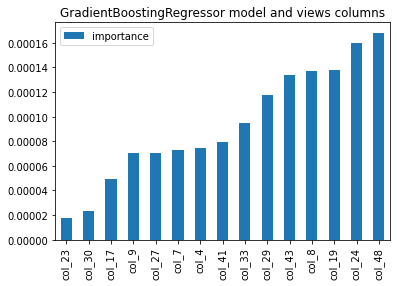

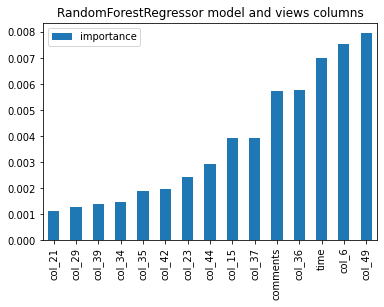

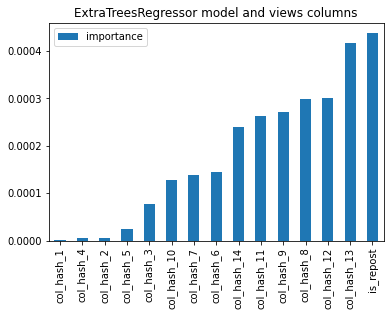

In [ ]:
dict_results = {}
status = False

for col in ['views']:
  X_train, X_test, y_train, y_test = get_data(X,y)
  dict_results[col] = {}
  for name, model in mls.items():
    if name not in ['linear', 'LassoCV', 'Ridge', 'ElasticNetCV']:
      status = True
    else:
      status = False

    results = get_score(col, name, model, X_train,  X_test, y_train, y_test, status)
    dict_results[col][name] = {'score_train' : results[0].round(3),'score_test' : results[1].round(3),
                               'cross_score': results[2].mean().round(3)}

In [ ]:
for k,v in dict_results.items():
  print(k)
  for ki,vi in v.items():
    print(ki, vi)
  print('-'*30)

views
GradientBoostingRegressor {'score_train': 0.873, 'score_test': 0.531, 'cross_score': 0.486}
linear {'score_train': 0.472, 'score_test': 0.478, 'cross_score': 0.187}
RandomForestRegressor {'score_train': 0.427, 'score_test': 0.317, 'cross_score': 0.334}
LassoCV {'score_train': 0.439, 'score_test': 0.4, 'cross_score': 0.438}
Ridge {'score_train': 0.472, 'score_test': 0.483, 'cross_score': 0.404}
ElasticNetCV {'score_train': 0.325, 'score_test': 0.319, 'cross_score': 0.377}
ExtraTreesRegressor {'score_train': 1.0, 'score_test': 0.54, 'cross_score': 0.624}
------------------------------


### Выбираем GradientBoostingRegressor,  LassoCV, ExtraTreesRegressor,RandomForestRegressor


In [32]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### GradientBoostingRegressor

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle = True)


parameters = {'learning_rate':  [0.1],           #[0.1, 0.3, 0.9],
                      'max_depth':  [90],             #[80, 90],
                      'max_features':  [3],             #[2, 3],
                      'min_samples_leaf': [4] }      #[3, 4, 5]}



model1 = GradientBoostingRegressor(random_state= 42)
grid = GridSearchCV(model1, parameters,  cv=3, verbose=True,
                               n_jobs= -1, scoring = 'r2')
grid.fit(X_train, y_train) 
grid.best_estimator_

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   30.3s finished


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=90,
                          max_features=3, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=4, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [35]:
grad_boost = pd.DataFrame({
    'r2_train': [r2_score(y_train, grid.predict(X_train)).round(6)],
    'r2_test': [r2_score(y_test, grid.predict(X_test)).round(6)],
    'MAE': [mean_absolute_error(y_test, grid.predict(X_test)).round(6)],
    'MSE': [mean_squared_error(y_test, grid.predict(X_test)).round(6)],
    'MAPE': [mean_absolute_percentage_error(y_test, grid.predict(X_test)).round(6)]}, index = ['GradientBoostingRegressor'])
grad_boost 

,r2_train,r2_test,MAE,MSE,MAPE
GradientBoostingRegressor,0.996458,0.458517,656.165034,8.235636e+06,inf


### LassoCV

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle = True)


parameters = {'n_alphas':  [120],                     #[80, 90,100,110,120]}
              'max_iter': [900, 950, 1000]}           # 900


model1 = LassoCV(random_state = 42)
grid2 = GridSearchCV(model1, parameters,  cv=5, verbose=True,
                               n_jobs= -1)
grid2.fit(X_train, y_train) 
grid2.best_estimator_

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    5.5s finished


LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
        max_iter=900, n_alphas=120, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=42, selection='cyclic',
        tol=0.0001, verbose=False)

In [37]:
grad_lasso = pd.DataFrame({
    'r2_train': [r2_score(y_train, grid2.predict(X_train)).round(6)],
    'r2_test': [r2_score(y_test, grid2.predict(X_test)).round(6)],
    'MAE': [mean_absolute_error(y_test, grid2.predict(X_test)).round(6)],
    'MSE': [mean_squared_error(y_test, grid2.predict(X_test)).round(3)],
    'MAPE': [mean_absolute_percentage_error(y_test, grid2.predict(X_test)).round(6)]}, index = ['lasso'])
grad_lasso

,r2_train,r2_test,MAE,MSE,MAPE
lasso,0.437958,0.398834,708.060591,9143372.374,inf


### RandomForestRegressor

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle = True)


parameters = {'n_estimators': [150],         #[110,120, 150]
              'max_depth': [15]}        #[15, 25, 40]


model1 = RandomForestRegressor(random_state = 42)
grid3 = GridSearchCV(model1, parameters,  cv=5, verbose=True,
                               n_jobs= -1)
grid3.fit(X_train, y_train) 
grid3.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 10.5min finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=15, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=150, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [39]:
grad_forest = pd.DataFrame({
    'r2_train': [r2_score(y_train, grid3.predict(X_train)).round(6)],
    'r2_test': [r2_score(y_test, grid3.predict(X_test)).round(6)],
    'MAE': [mean_absolute_error(y_test, grid3.predict(X_test)).round(6)],
    'MSE': [mean_squared_error(y_test, grid3.predict(X_test)).round(3)],
    'MAPE': [mean_absolute_percentage_error(y_test, grid3.predict(X_test)).round(6)]}, index = ['RandomForest'])
grad_forest

,r2_train,r2_test,MAE,MSE,MAPE
RandomForest,0.923605,0.488989,461.039149,7772168.41,inf


### ExtraTreesRegressor

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle = True)


parameters = {'n_estimators':  [150],           #[110,120, 150, 200],
              'max_depth': [7] }           #[20,30]} 


model1 = ExtraTreesRegressor(random_state = 42)
grid4 = GridSearchCV(model1, parameters,  cv=5, verbose=True,
                               n_jobs= -1)
grid4.fit(X_train, y_train) 
grid4.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.1s finished


ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=7, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=150, n_jobs=None, oob_score=False,
                    random_state=42, verbose=0, warm_start=False)

In [41]:
grad_extra = pd.DataFrame({
    'r2_train': [r2_score(y_train, grid4.predict(X_train)).round(6)],
    'r2_test': [r2_score(y_test, grid4.predict(X_test)).round(6)],
    'MAE': [mean_absolute_error(y_test, grid4.predict(X_test)).round(6)],
    'MSE': [mean_squared_error(y_test, grid4.predict(X_test)).round(3)],
    'MAPE': [mean_absolute_percentage_error(y_test, grid4.predict(X_test)).round(6)]}, index = ['ExtraTrees'])
grad_extra

,r2_train,r2_test,MAE,MSE,MAPE
ExtraTrees,0.645742,0.511476,570.163275,7430151.501,inf


Используем стеккинг моделей для получения лучшего результата наших обученных моделей

### Stacking

In [42]:
estimators = [
    ('GradientBoosting', grid.best_estimator_),
    ('LassoCV', grid2.best_estimator_),
    ('ExtraTrees', grid4.best_estimator_),
    ('RandomForest', grid3.best_estimator_)
]
reg = StackingRegressor(
    estimators=estimators)
reg.fit(X_train, y_train) 

StackingRegressor(cv=None,
                  estimators=[('GradientBoosting',
                               GradientBoostingRegressor(alpha=0.9,
                                                         ccp_alpha=0.0,
                                                         criterion='friedman_mse',
                                                         init=None,
                                                         learning_rate=0.1,
                                                         loss='ls',
                                                         max_depth=90,
                                                         max_features=3,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=4,
                      

In [43]:
new1 = pd.DataFrame({
    'r2_train': [r2_score(y_train, reg.predict(X_train)).round(6)],
    'r2_test': [r2_score(y_test, reg.predict(X_test)).round(6)],
    'MAE': [mean_absolute_error(y_test, reg.predict(X_test)).round(6)],
    'MSE': [mean_squared_error(y_test, reg.predict(X_test)).round(3)],
    'MAPE': [mean_absolute_percentage_error(y_test, reg.predict(X_test)).round(6)]}, index = ['Stacking'])
new1

,r2_train,r2_test,MAE,MSE,MAPE
Stacking,0.837606,0.531046,479.734786,7132517.323,inf


In [44]:
all_vk = pd.concat([grad_boost, grad_lasso, grad_extra, new1])
all_vk

,r2_train,r2_test,MAE,MSE,MAPE
GradientBoostingRegressor,0.996458,0.458517,656.165034,8.235636e+06,inf
lasso,0.437958,0.398834,708.060591,9.143372e+06,inf
ExtraTrees,0.645742,0.511476,570.163275,7.430152e+06,inf
Stacking,0.837606,0.531046,479.734786,7.132517e+06,inf


In [78]:
views = pd.DataFrame()
for id_post in range(5):
  view = []
  for day in range(1,11):
    X = new_data.drop(['views'], axis = 1)
    X.loc[id_post,'time'] += 60*60*24*day
    for col in cols:
      X[[col]] = num_scaler.fit_transform(X[[col]])
    view.append(reg.predict([X.loc[id_post,:]])[0] + y[id_post])
  views[f"{df.loc[:,['author_id']].values[id_post][0]} id"] = view

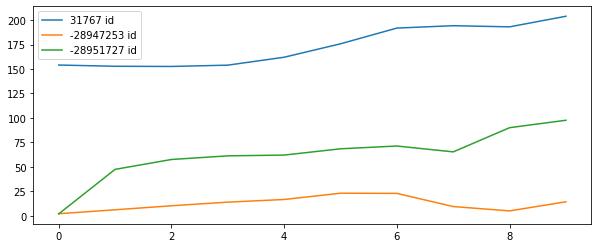

In [80]:
views.plot(figsize = (10,4))

## работа с telegram

Делаем все тоже самое, только с данными из телеграмма

### обработка данных

In [81]:
tg_df['created_date'] = pd.to_datetime(tg_df['created_date'])
tg_df['updated_date'] = pd.to_datetime(tg_df['updated_date'])

In [82]:
tg_df['time'] = pd.to_timedelta(tg_df['updated_date'] - tg_df['created_date']).apply(lambda x: x.total_seconds())

In [83]:
tg_df['edit_text'] = tg_df['text'].apply(lambda x: BeautifulSoup(str(x), 'lxml').text)
tg_df['text'] = tg_df['edit_text'].apply(lambda x: x.split('#')[0])
tg_df['hashtags'] =  tg_df['edit_text'].apply(lambda x: ' '.join(re.findall(r'#\w+', x)).strip()) 

In [84]:
stemmer = SnowballStemmer("russian")
tg_df['stem_text'] = tg_df['edit_text'].apply(lambda x: ' '.join([stemmer.stem(w) for w in x.split(' ')]))

In [85]:
vectorizer = CountVectorizer(analyzer='word', ngram_range=(2, 2))
X2 = vectorizer.fit_transform(tg_df['stem_text'])

In [86]:
X3 = vectorizer.fit_transform(tg_df['hashtags'])

In [87]:
pca = TruncatedSVD(n_components=50, n_iter=7, random_state=42)
new_data = pd.DataFrame(pca.fit_transform(X2), columns = [f'col_{i}' for i in range(1,51)])

In [88]:
pca = TruncatedSVD(n_components=15, n_iter=7, random_state=42)
new_hash = pd.DataFrame(pca.fit_transform(X3), columns = [f'col_hash_{i}' for i in range(1,16)])

In [89]:
cols = ['has_images', 'has_videos', 'version','author_subscribers','time','views']
for col in cols:
  new_data[col] = tg_df[col].values

In [90]:
for col in new_hash.columns:
  new_data[col] = new_hash[col]

In [91]:
X = new_data.drop(['views'], axis = 1)
y = new_data['views'].values

In [92]:
num_scaler = StandardScaler()
cols.remove('views')

for col in cols:
  X[[col]] = num_scaler.fit_transform(X[[col]])

In [93]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

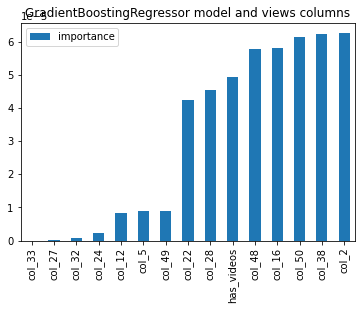

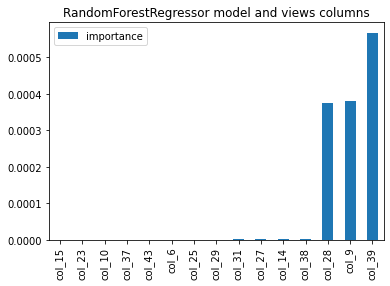

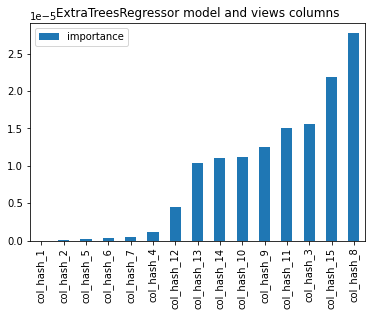

In [94]:
dict_results = {}
status = False

for col in ['views']:
  X_train, X_test, y_train, y_test = get_data(X,y)
  dict_results[col] = {}
  for name, model in mls.items():
    if name not in ['linear', 'LassoCV', 'Ridge', 'ElasticNetCV']:
      status = True
    else:
      status = False

    results = get_score(col, name, model, X_train,  X_test, y_train, y_test, status)
    dict_results[col][name] = {'score_train' : results[0].round(3),'score_test' : results[1].round(3),
                               'cross_score': results[2].mean().round(3)}

In [95]:
for k,v in dict_results.items():
  print(k)
  for ki,vi in v.items():
    print(ki, vi)
  print('-'*30)

views
GradientBoostingRegressor {'score_train': 0.963, 'score_test': 0.783, 'cross_score': 0.086}
linear {'score_train': 0.4, 'score_test': -940.446, 'cross_score': -5122.194}
RandomForestRegressor {'score_train': 0.79, 'score_test': 0.692, 'cross_score': 0.384}
LassoCV {'score_train': 0.39, 'score_test': 0.319, 'cross_score': 0.364}
Ridge {'score_train': 0.4, 'score_test': 0.289, 'cross_score': 0.343}
ElasticNetCV {'score_train': 0.149, 'score_test': 0.14, 'cross_score': 0.175}
ExtraTreesRegressor {'score_train': 1.0, 'score_test': 0.836, 'cross_score': 0.41}
------------------------------


### Выбираем GradientBoostingRegressor, RandomForestRegressor, LassoCV

### GradientBoostingRegressor

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle = True)


parameters = {'learning_rate':  [0.1],           #[0.1,0.3,0.5,0.7,0.9],
                      'max_depth':  [20],             #[20,30,40,50],
                      'max_features':  [2],             #[2, 3],
                      'min_samples_leaf': [5] }      #[3, 4, 5]}



model1 = GradientBoostingRegressor(random_state= 42)
grid = GridSearchCV(model1, parameters,  cv=3, verbose=True,
                               n_jobs= -1, scoring = 'r2')
grid.fit(X_train, y_train) 
grid.best_estimator_

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.4s finished


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=20,
                          max_features=2, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=5, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [97]:
grad_boost = pd.DataFrame({
    'r2_train': [r2_score(y_train, grid.predict(X_train)).round(6)],
    'r2_test': [r2_score(y_test, grid.predict(X_test)).round(6)],
    'MAE': [mean_absolute_error(y_test, grid.predict(X_test)).round(6)],
    'MSE': [mean_squared_error(y_test, grid.predict(X_test)).round(6)],
    'MAPE': [mean_absolute_percentage_error(y_test, grid.predict(X_test)).round(6)]}, index = ['GradientBoostingRegressor'])
grad_boost 

,r2_train,r2_test,MAE,MSE,MAPE
GradientBoostingRegressor,0.986652,0.51652,1024.516972,1.783509e+07,inf


### RandomForestRegressor

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle = True)


parameters = {'n_estimators': [200],         #[110,120, 150]
              'max_depth': [15]}        #[15, 25, 40]


model1 = RandomForestRegressor(random_state = 42)
grid3 = GridSearchCV(model1, parameters,  cv=5, verbose=True,
                               n_jobs= -1)
grid3.fit(X_train, y_train) 
grid3.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.0min finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=15, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [99]:
grad_forest = pd.DataFrame({
    'r2_train': [r2_score(y_train, grid3.predict(X_train)).round(6)],
    'r2_test': [r2_score(y_test, grid3.predict(X_test)).round(6)],
    'MAE': [mean_absolute_error(y_test, grid3.predict(X_test)).round(6)],
    'MSE': [mean_squared_error(y_test, grid3.predict(X_test)).round(3)],
    'MAPE': [mean_absolute_percentage_error(y_test, grid3.predict(X_test)).round(6)]}, index = ['RandomForest'])
grad_forest

,r2_train,r2_test,MAE,MSE,MAPE
RandomForest,0.958886,0.749432,524.649962,9243225.387,inf


### LassoCV

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle = True)


parameters = {'n_alphas':  [120,130,140],                     #[80, 90,100,110,120]}
              'max_iter': [900, 950, 1000]}           # 900


model1 = LassoCV(random_state = 42)
grid2 = GridSearchCV(model1, parameters,  cv=5, verbose=True,
                               n_jobs= -1)
grid2.fit(X_train, y_train) 
grid2.best_estimator_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    6.4s finished


LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
        max_iter=900, n_alphas=120, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=42, selection='cyclic',
        tol=0.0001, verbose=False)

In [101]:
grad_lasso = pd.DataFrame({
    'r2_train': [r2_score(y_train, grid2.predict(X_train)).round(6)],
    'r2_test': [r2_score(y_test, grid2.predict(X_test)).round(6)],
    'MAE': [mean_absolute_error(y_test, grid2.predict(X_test)).round(6)],
    'MSE': [mean_squared_error(y_test, grid2.predict(X_test)).round(3)],
    'MAPE': [mean_absolute_percentage_error(y_test, grid2.predict(X_test)).round(6)]}, index = ['lasso'])
grad_lasso

,r2_train,r2_test,MAE,MSE,MAPE
lasso,0.390495,0.31897,939.713649,2.512255e+07,inf


### Stacking

In [102]:
estimators = [
    ('GradientBoosting', grid.best_estimator_),
    ('LassoCV', grid2.best_estimator_),
    ('RandomForest', grid3.best_estimator_)
]
reg_tg = StackingRegressor(
    estimators=estimators)
reg_tg.fit(X_train, y_train) 

StackingRegressor(cv=None,
                  estimators=[('GradientBoosting',
                               GradientBoostingRegressor(alpha=0.9,
                                                         ccp_alpha=0.0,
                                                         criterion='friedman_mse',
                                                         init=None,
                                                         learning_rate=0.1,
                                                         loss='ls',
                                                         max_depth=20,
                                                         max_features=2,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=5,
                      

In [103]:
new1 = pd.DataFrame({
    'r2_train': [r2_score(y_train, reg_tg.predict(X_train)).round(6)],
    'r2_test': [r2_score(y_test, reg_tg.predict(X_test)).round(6)],
    'MAE': [mean_absolute_error(y_test, reg_tg.predict(X_test)).round(6)],
    'MSE': [mean_squared_error(y_test, reg_tg.predict(X_test)).round(6)],
    'MAPE': [mean_absolute_percentage_error(y_test, reg_tg.predict(X_test)).round(6)]}, index = ['Stacking'])
new1

,r2_train,r2_test,MAE,MSE,MAPE
Stacking,0.946203,0.750605,570.597301,9.199952e+06,inf


In [104]:
all_tg = pd.concat([grad_boost, grad_lasso, grad_forest, new1])
all_tg

,r2_train,r2_test,MAE,MSE,MAPE
GradientBoostingRegressor,0.986652,0.516520,1024.516972,1.783509e+07,inf
lasso,0.390495,0.318970,939.713649,2.512255e+07,inf
RandomForest,0.958886,0.749432,524.649962,9.243225e+06,inf
Stacking,0.946203,0.750605,570.597301,9.199952e+06,inf


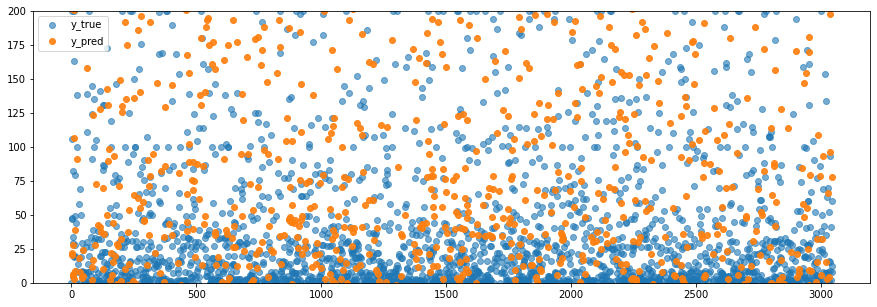

In [105]:
pred_df=pd.DataFrame({'true':y_test,'pred':reg_tg.predict(X_test)})
plt.figure(figsize=(15,5))
plt.scatter(range(pred_df.shape[0]),pred_df['true'], label = 'y_true', alpha = 0.6)
plt.scatter(range(pred_df.shape[0]),pred_df['pred'], label = 'y_pred', alpha = 0.9)
plt.ylim(0, 200)
plt.legend()
plt.show()

In [106]:
X = new_data.drop(['views'], axis = 1)
y = new_data['views'].values

In [111]:
views = pd.DataFrame()
for id_post in range(5):
  view = []
  for day in range(1,11):
    X = new_data.drop(['views'], axis = 1)
    X.loc[id_post,'time'] += 60*60*24*day
    for col in cols:
      X[[col]] = num_scaler.fit_transform(X[[col]])
    view.append(reg_tg.predict([X.loc[id_post,:]])[0] + y[id_post])
  views[f"{tg_df.loc[:,['author_id']].values[id_post][0]} id"] = view

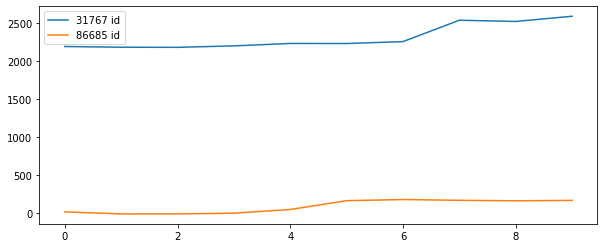

In [112]:
views.plot(figsize = (10,4))

## работа с одноклассниками

In [274]:
df = pd.read_csv('datav.02.csv')
od_df = df[df['social_type'] == 'odnoklassniki']

In [275]:
od_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17042 entries, 29928 to 58425
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          17042 non-null  int64 
 1   social_type         17042 non-null  object
 2   text                16894 non-null  object
 3   has_images          17042 non-null  int64 
 4   has_videos          17042 non-null  int64 
 5   url                 17042 non-null  object
 6   likes               17042 non-null  int64 
 7   comments            17042 non-null  int64 
 8   reposts             17042 non-null  int64 
 9   views               17042 non-null  int64 
 10  is_repost           17042 non-null  int64 
 11  created_date        17042 non-null  object
 12  updated_date        17042 non-null  object
 13  version             17042 non-null  int64 
 14  author_id           17042 non-null  int64 
 15  id                  17042 non-null  object
 16  author_subscribers

In [276]:
def get_time(i):
  try:
    o = od_df['updated_date'].iloc[i,]
    o = datetime.datetime.strptime(o, '%Y-%m-%d %H:%M:%S')
    k = (o - pd.to_datetime(od_df['created_date'].iloc[i,])).total_seconds()
    return k
  except:
    k = pd.Timedelta('12 days 23:14:26').total_seconds()
    return k


In [277]:
od_df['time'] = [abs(get_time(i)) for i in range(od_df.shape[0])]

In [278]:
od_df['edit_text'] = od_df['text'].apply(lambda x: BeautifulSoup(str(x), 'lxml').text)
od_df['text'] = od_df['edit_text'].apply(lambda x: x.split('#')[0])
od_df['hashtags'] =  od_df['edit_text'].apply(lambda x: ' '.join(re.findall(r'#\w+', x)).strip()) 

In [279]:
stemmer = SnowballStemmer("russian")
od_df['stem_text'] = od_df['edit_text'].apply(lambda x: ' '.join([stemmer.stem(w) for w in x.split(' ')]))

In [280]:
vectorizer = CountVectorizer(analyzer='word', ngram_range=(2, 2))
X2 = vectorizer.fit_transform(od_df['stem_text'])

In [281]:
X3 = vectorizer.fit_transform(od_df['hashtags'])

In [283]:
pca = TruncatedSVD(n_components=5, n_iter=7, random_state=42)
new_data = pd.DataFrame(pca.fit_transform(X2), columns = [f'col_{i}' for i in range(1,6)])

In [284]:
pca = TruncatedSVD(n_components=3, n_iter=7, random_state=42)
new_hash = pd.DataFrame(pca.fit_transform(X3), columns = [f'col_hash_{i}' for i in range(1,4)])

In [267]:
od_df.head(1)

,Unnamed: 0,social_type,text,has_images,has_videos,url,likes,comments,reposts,views,is_repost,created_date,updated_date,version,author_id,id,author_subscribers,time,edit_text,hashtags,stem_text
29928,63595,odnoklassniki,"МРОТ должен быть не меньше 50 тысяч рублей, и...",1,0,https://ok.ru/group/54891722506250/topic/15306...,0,0,1,-1,0,2021-04-07 09:15:00,2021-04-08 15:57:38,2,54891722506250,group/54891722506250/topic/153069889063690,8782,110558.0,"МРОТ должен быть не меньше 50 тысяч рублей, и...",#экспрессгазета #политика #МРОТ,"мрот долж быт не меньш 50 тысяч рублей, ил о ..."


In [285]:
cols = ['has_images', 'has_videos', 'likes', 'comments', 'version', 'reposts', 'is_repost', 'version', 'author_subscribers','time']
for col in cols:
  new_data[col] = od_df[col].values

In [286]:
for col in new_hash.columns:
  new_data[col] = new_hash[col]

In [287]:
for col in cols:
  new_data[[col]] = num_scaler.fit_transform(new_data[[col]])

In [288]:
new_data

,col_1,col_2,col_3,col_4,col_5,has_images,has_videos,likes,comments,version,reposts,is_repost,author_subscribers,time,col_hash_1,col_hash_2,col_hash_3
0,0.016027,0.019245,0.009126,0.042111,0.020157,0.374076,0.0,-0.059804,-0.077,-0.727103,-0.037595,0.0,-0.255526,-1.133466,4.591731e-16,-2.554371e-15,1.086856e-14
1,0.002057,0.002600,0.000657,0.004516,0.005462,0.374076,0.0,-0.059804,-0.077,-0.727103,-0.093085,0.0,-0.255526,-1.131184,-5.745397e-04,4.717361e-04,-7.836801e-05
2,0.001047,0.000795,0.000211,0.001350,0.000861,0.374076,0.0,-0.054637,-0.077,-0.727103,-0.037595,0.0,-0.255526,-1.338562,-5.745397e-04,4.717361e-04,-7.836801e-05
3,0.069157,0.006990,0.000734,0.005903,0.014523,0.374076,0.0,-0.059804,-0.077,-0.727103,-0.093085,0.0,-0.255526,-1.332970,-5.745397e-04,4.717361e-04,-7.836801e-05
4,0.000302,0.000469,0.000143,0.000966,0.000406,0.374076,0.0,-0.059804,-0.077,-0.727103,-0.037595,0.0,-0.255526,-1.332741,-1.722559e-17,2.741637e-18,1.428276e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17037,0.151380,0.220881,0.070096,0.298628,0.081902,0.374076,0.0,-0.057220,-0.077,3.144323,-0.037595,0.0,-0.325902,0.787495,-0.000000e+00,-0.000000e+00,-0.000000e+00
17038,0.051685,0.086457,0.040698,0.157312,0.005771,0.374076,0.0,-0.049470,-0.077,2.880363,-0.037595,0.0,-0.308633,0.787495,-0.000000e+00,-0.000000e+00,-0.000000e+00
17039,0.000144,0.000112,0.000108,0.000501,-0.000123,-2.673251,0.0,-0.054637,-0.077,2.792376,-0.093085,0.0,-0.305384,0.787495,5.804780e-15,-3.973643e-15,1.741624e-14
17040,0.021184,0.021610,0.009332,0.050402,0.025022,0.374076,0.0,-0.059804,-0.077,2.880363,-0.093085,0.0,-0.327800,0.787495,9.983659e-18,-3.463358e-17,7.638079e-17


In [289]:
link = linkage(new_data, 'ward', 'euclidean')

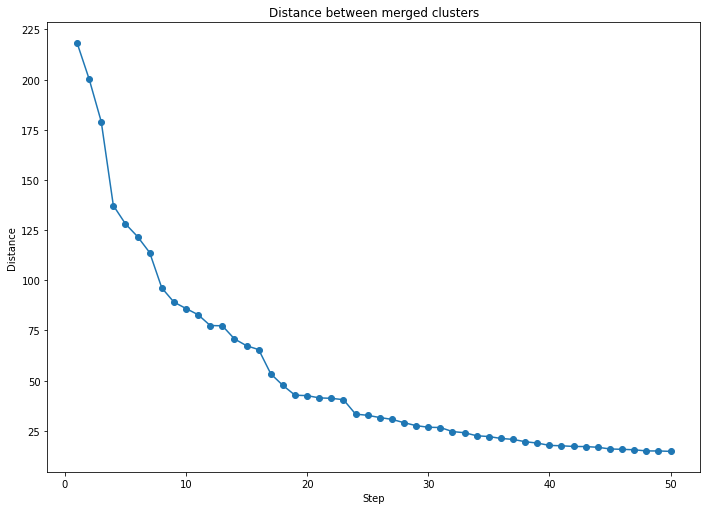

In [291]:
dist = link[-50:, 2]
dist_rev = dist[::-1]
idxs = range(1, len(dist) + 1)

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
plt.plot(idxs, dist_rev, marker='o')
plt.title('Distance between merged clusters')
plt.xlabel('Step')
plt.ylabel('Distance')

plt.show()

In [303]:
od_df['cluster'] = fcluster(link, 8, criterion='maxclust')

In [308]:
info = od_df.groupby('cluster').mean()[cols]
info['time'] = info['time']/60/60
info

,has_images,has_videos,likes,comments,version,reposts,is_repost,version,author_subscribers,time
cluster,,,,,,,,,,
1,0.500000,0.0,3098.500000,1520.000000,8.000000,308.750000,0.0,8.000000,756174.000000,311.240556
2,1.000000,0.0,18699.600000,327.200000,6.800000,736.800000,0.0,6.800000,812233.000000,311.240556
3,1.000000,0.0,1.935164,0.264992,2.322040,0.313474,0.0,2.322040,16065.303738,11.313132
4,0.687500,0.0,5176.375000,113.500000,5.000000,281.000000,0.0,5.000000,486785.000000,217.604497
5,0.929524,0.0,121.407619,21.869524,3.992381,8.252381,0.0,3.992381,365895.854286,89.538879
6,0.000000,0.0,8.505221,0.794630,12.040776,1.027350,0.0,12.040776,32623.694679,219.599293
7,1.000000,0.0,6.946498,0.439321,32.787734,0.940844,0.0,32.787734,10363.453241,311.240556
8,1.000000,0.0,5.412667,0.601135,9.056586,0.715994,0.0,9.056586,13499.986965,311.106429


In [319]:
info['k1'] = 100*(info['likes'] + info['comments'])/info['author_subscribers']
info['k2'] = (info['likes'])/info['time']

info.sort_values(by='k1')

,has_images,has_videos,likes,comments,version,reposts,is_repost,version,author_subscribers,time,k1,k2
cluster,,,,,,,,,,,,
3,1.000000,0.0,1.935164,0.264992,2.322040,0.313474,0.0,2.322040,16065.303738,11.313132,0.013695,0.171055
6,0.000000,0.0,8.505221,0.794630,12.040776,1.027350,0.0,12.040776,32623.694679,219.599293,0.028506,0.038731
5,0.929524,0.0,121.407619,21.869524,3.992381,8.252381,0.0,3.992381,365895.854286,89.538879,0.039158,1.355921
8,1.000000,0.0,5.412667,0.601135,9.056586,0.715994,0.0,9.056586,13499.986965,311.106429,0.044547,0.017398
7,1.000000,0.0,6.946498,0.439321,32.787734,0.940844,0.0,32.787734,10363.453241,311.240556,0.071268,0.022319
1,0.500000,0.0,3098.500000,1520.000000,8.000000,308.750000,0.0,8.000000,756174.000000,311.240556,0.610772,9.955322
4,0.687500,0.0,5176.375000,113.500000,5.000000,281.000000,0.0,5.000000,486785.000000,217.604497,1.086696,23.787996
2,1.000000,0.0,18699.600000,327.200000,6.800000,736.800000,0.0,6.800000,812233.000000,311.240556,2.342530,60.080859


* cluster 2 - хорошая, живая группа, охват средний,  подписчиков много, однако активных мало, преимущественно с фото
* cluster 4 - хорошая живая группа, охват средний, подписчиков мало для такого с фото и без  
* cluster 1 - группа с накруткой подписчиков, кол-во лайков среднее по отношению к общему количеству
* cluster 7 - развивающееся группа, кол-во активных подписчиков растет, хороший потенциал для дальнейшего сотрудничества
* cluster 8 - развивающееся группа, кол-во активных подписчиков растет, в будущем, возможно, будет хороший потенциал для сотрудничества
* cluster 5 - мертвая группа, возможно сильная накрутка или перепродажа сообщества
* cluster 6 - средний сегмент группы, количество подписчиков среднее, интересный вариант для сотрудничества
* cluster 3 - группа полумертвая, подписчики неохотно просматривают посты.

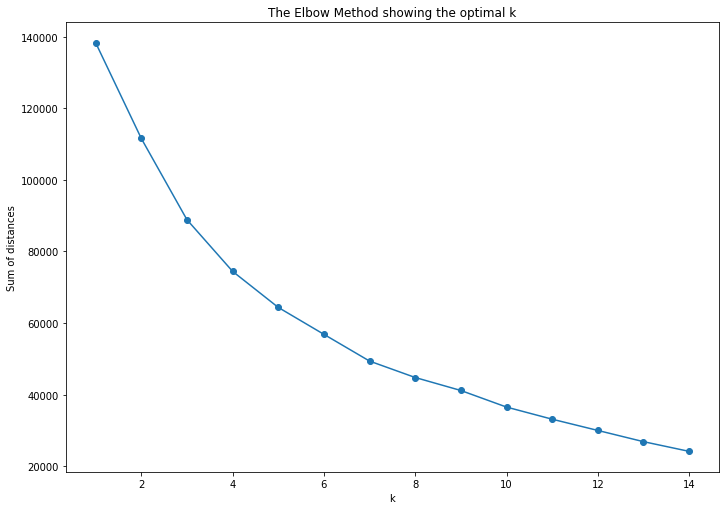

In [322]:
K = range(1, 15)
models = [KMeans(n_clusters=k, random_state=42).fit(new_data) for k in K]
dist = [model.inertia_ for model in models]
#Метод inertia_ вернёт сумму расстояний от каждой точки данных до центра ближайшего у ней кластера. 
#кластеризацию можно считать условно хорошей, когда инерция перестаёт сильно уменьшаться при увеличении числа кластеров.



fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
plt.plot(K, dist, marker='o')
plt.xlabel('k')
plt.ylabel('Sum of distances')
plt.title('The Elbow Method showing the optimal k')
plt.show()